In [1]:
library(dplyr)
library(ggplot2)
data1 = read.table('igblast_umicorrected.tab', header = 1, stringsAsFactors = FALSE, sep = ',')

data1$lane = 1

data = data1

data = data  %>% rename(CLUSTER_ID = SEQUENCE_ID)

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
data$BC_UMI = gsub(x = data$CORRECTED_ID, pattern = '[^A-Z.-]', replacement = '')
data$BC = substring(data$BC_UMI, 1, 12)
data$UMI = substring(data$BC_UMI, 13, 20)
data$CLUSTER = gsub(x = data$CLUSTER_ID, pattern = '[^0-9.-]', replacement = '')                  
head(data %>% select(CLUSTER_ID, BC_UMI, BC, UMI, CLUSTER))

,CLUSTER_ID,BC_UMI,BC,UMI,CLUSTER
,<chr>,<chr>,<chr>,<chr>,<chr>
1,1NTCGTGTGATATATCCACCC,CTCGTGTGATATATCCACCC,CTCGTGTGATAT,ATCCACCC,1
2,1NCTGTTCGAGTCCGGGGGAC,ACTGTTCGAGTCCGGGGGAC,ACTGTTCGAGTC,CGGGGGAC,1
3,1NGACGCGAAGACGTTTTTTG,GGACGCGAAGACGTTTTTTG,GGACGCGAAGAC,GTTTTTTG,1
4,3NGTAGAGGTAACGCAGAACT,CGTAGAGGTAACGCAGAACT,CGTAGAGGTAAC,GCAGAACT,3
5,5NGTAGAGGTAACGCAGAACT,CGTAGAGGTAACGCAGAACT,CGTAGAGGTAAC,GCAGAACT,5
6,1NCGAGAGGGCTATCTGCCAG,CCGAGAGGGCTATCTGCCAG,CCGAGAGGGCTA,TCTGCCAG,1


In [3]:
data$uncorrected = substring( gsub(x = data$CLUSTER_ID, pattern = '[^A-Z.-]', replacement = ''), 1, 20)

In [4]:
data %>% group_by(BC_UMI) %>% summarize(n = length(unique(uncorrected))) %>% filter(n > 3)  %>% head(10)

BC_UMI,n
<chr>,<int>
AAAAAAAAAAAAAAAACATG,4
AAAAAAACTCACATCGAAAG,10
AAAAAAAGCCCCGGGAGCAT,5
AAAAAAAGTCCTTAAGGTAG,41
AAAAAACGCTCTTGAGTGGG,4
AAAAAACTGCCGGGAACCCA,5
AAAAAAGCAATGAAGCCCAC,6
AAAAAAGCAATGCGCGACGG,6
AAAAAAGCAATGTGCGAACA,5


In [5]:


stats_summary = data %>% filter(BC_UMI == uncorrected) %>% group_by(BC_UMI, BC, UMI) %>% summarize(nUMI = sum(CONSCOUNT), UMI_COUNT = n()) %>% as.data.frame()
rownames(stats_summary) = stats_summary$BC_UMI
head(stats_summary)

`summarise()` has grouped output by 'BC_UMI', 'BC'. You can override using the `.groups` argument.


,BC_UMI,BC,UMI,nUMI,UMI_COUNT
,<chr>,<chr>,<chr>,<int>,<int>
AAAAAAAAAAAAAAAAAAAC,AAAAAAAAAAAAAAAAAAAC,AAAAAAAAAAAA,AAAAAAAC,24,1
AAAAAAAAAAAAAAAAAACA,AAAAAAAAAAAAAAAAAACA,AAAAAAAAAAAA,AAAAAACA,23,1
AAAAAAAAAAAAAAAAACAT,AAAAAAAAAAAAAAAAACAT,AAAAAAAAAAAA,AAAAACAT,14,2
AAAAAAAAAAAAAAAACATG,AAAAAAAAAAAAAAAACATG,AAAAAAAAAAAA,AAAACATG,7,1
AAAAAAAAAAAAAAACATGC,AAAAAAAAAAAAAAACATGC,AAAAAAAAAAAA,AAACATGC,4,1
AAAAAAAAAAAAAACATGCA,AAAAAAAAAAAAAACATGCA,AAAAAAAAAAAA,AACATGCA,4,1


In [6]:
data$nUMI = stats_summary[data$BC_UMI, 'nUMI']
data = data %>% mutate(UMI_FRAC = CONSCOUNT/nUMI) 
summary(data$UMI_FRAC)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  0.00000   0.00118   0.00408   0.14765   0.03333 227.81818 

In [7]:
data$AMBIG = FALSE
data$AMBIG[grep(pattern = 'N', x = data$JUNCTION)] = TRUE
table(data$AMBIG)



  FALSE    TRUE 
2614425  846054 

In [8]:
sub = data %>% filter(BC_UMI == uncorrected)
summary(sub$UMI_FRAC)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000038 0.0013947 0.0061958 0.2345486 0.3000000 1.0000000 

In [9]:
hash = readRDS('../cell hashing/hashed_meta.RDS')

In [10]:
seurat = readRDS('../initialSeurat.RDS')


[1] 56108    64

Loading required package: Seurat

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: Matrix




        0         1         2         3 
0.5057977 0.1900892 0.1815365 0.1225766 

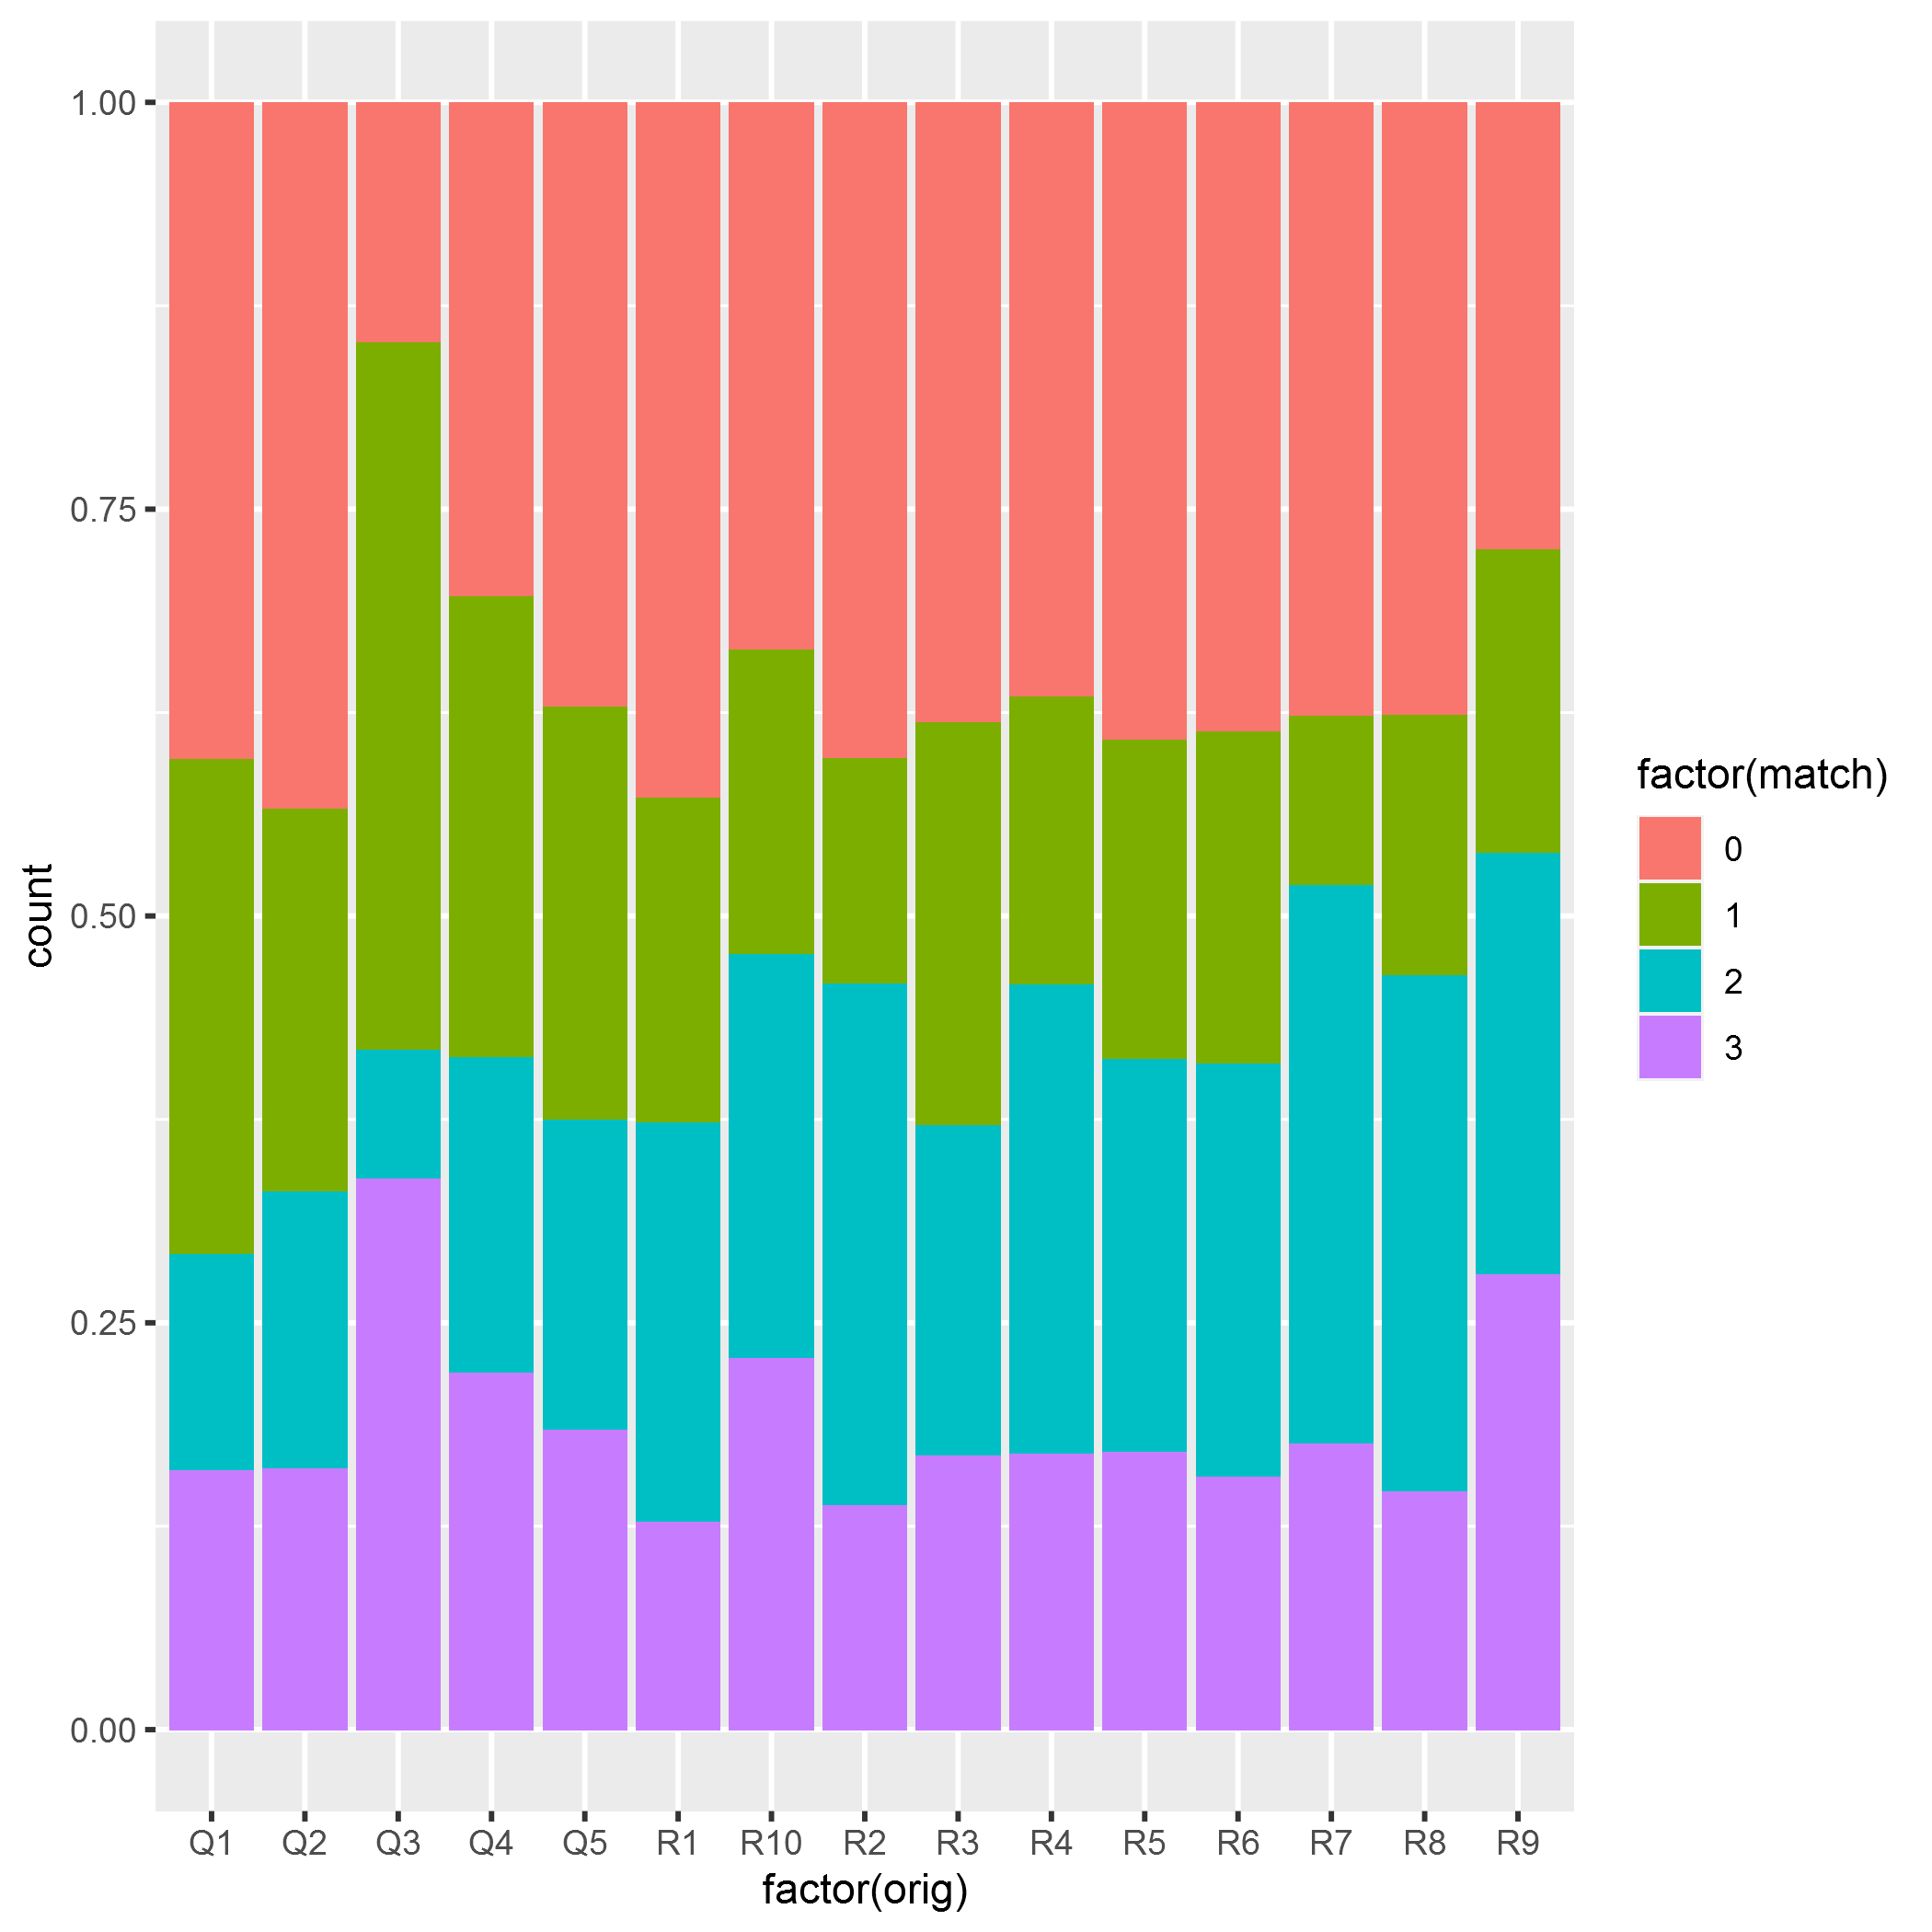

In [11]:
seurat = readRDS('../initialSeurat.RDS')
options(repr.plot.res = 300)
matches = sub %>% ungroup() %>% filter(BC %in% seurat@meta.data$bc, nUMI >5, !AMBIG, UMI_FRAC > 0.9)
dim(matches)
seurat@meta.data$matchedB = as.numeric(seurat@meta.data$bc %in% matches$BC[matches$LOCUS == 'TRB'])
seurat@meta.data$matchedA = as.numeric(seurat@meta.data$bc %in% matches$BC[matches$LOCUS == 'TRA'])
seurat@meta.data$match = 2*seurat@meta.data$matchedB + seurat@meta.data$matchedA
table(seurat@meta.data$match)/length(seurat@meta.data$match)
ggplot(seurat@meta.data %>% filter(n_genes > 750), aes(x = factor(orig), fill = factor(match))) + geom_bar(position = 'fill') 

In [12]:
mode= function(x) {
    ret = NA
    if (length(x) > 0){
    tab = table(x)
    tab = tab[order(tab, decreasing = TRUE)]
    ret = names(tab)[1]
        }
    as.character(ret)
}
mode2= function(x) {
    ret = NA
    if (length(x) > 0){
    tab = table(x)
    tab = tab[order(tab, decreasing = TRUE)]
        if (length(tab) > 1) {
    ret = names(tab)[2]}
        }
    as.character(ret)
}

In [13]:
library(alakazam)
#matches= sub %>% filter(BC %in% seurat@meta.data$bc,nUMI > 5, !AMBIG, UMI_FRAC > 0.9)
matches$CDR3 = translateDNA(matches$JUNCTION)
matches$TopVregion = matches$V_CALL
matches$TopJregion = matches$J_CALL
matches$nReads = matches$CONSCOUNT
matches$CDR3nuc =matches$CDR3_IMGT
head(matches$CDR3)



As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.



[1] "CALRNSNNRIFF"   "CAASDYSNNRLT"   "CASSQTGDSYEQYF" NA              
[5] "CASSHPGSQNTLYF" "CALSIPTKSS"

In [14]:
TCR_df = matches

metadata = seurat@meta.data
metadata$TRB_CDR3 = NA
metadata$TRBV = NA


# Clean & Format ----------------------------------------------------------
#Then let's clean cast some variable into usable formats
TCR_df <- TCR_df %>% mutate(TopVregion = factor(TopVregion), TopJregion = factor(TopJregion))

#Clean the TCR from umi that gave no CDR3. then orders first by BC, then by nReads within each BC
TCR_df_cleaned <- TCR_df %>% filter(!is.na(CDR3)) %>% arrange(BC, desc(nReads))

#I think there are still several things to do. One is to quantify how many UMI each CDR3 has,
#and then sort the files by UMI, then by reads.

#here we create a second df that records (BC,CDR3) combination and their respective UMI_count
#The unique argument is key here. It prevent double countings
TCR_df_cleaned_UMI_count <- TCR_df_cleaned %>% count(BC, CDR3) %>% rename(UMI_count = n)

#then we make merge the two, grouped by Barcode and CDR3
TCR_df_cleaned<-left_join(TCR_df_cleaned, TCR_df_cleaned_UMI_count, by = c('BC','CDR3')) #%>% arrange(BC, desc(UMI_count),desc(nReads))

#re-order a little bit for readability
TCR_df_cleaned<- TCR_df_cleaned %>% select(BC,UMI,UMI_count,nReads,everything())

#then re-order the rows again just to make sure the top UMI_count/nReads results are at the top of each 
#cell barcode group.
TCR_df_cleaned<- TCR_df_cleaned[with(TCR_df_cleaned,order(BC,UMI_count,nReads,decreasing=TRUE)),]

#Separate df into alpha and beta chain into two dataframes

TRA_df <- TCR_df_cleaned %>% filter(LOCUS == 'TRA')
TRB_df <- TCR_df_cleaned %>% filter(LOCUS == 'TRB') %>% filter(FUNCTIONAL)


#Then we should generate masks of matching barcodes. We would probably have to do two masks
#Note: these values are just masks that apply to (not BCseq, but) TRA/TRB_df list of values. i.e. it gives
#indices of where in the TRA/TRB_df, do you find the correspoding rank position of the same cell (i.e. first
#position is first cell in the BCSeqlist.)
#BCSeq has to be the total list of barcodes for all of the cells in the Seurat object

BCSeq = metadata$bc
is.na(match(BCSeq, TRA_df$BC)) == 0 -> TRA_BC 
is.na(match(BCSeq, TRB_df$BC)) == 0 -> TRB_BC 
TRA_BC & TRB_BC ->TRAB_BC

#is.na(match(BCSeq, TCR_df$BC)) == 0 -> TCR_BC
#is.na(match(BCSeq, TCR_df_cleaned$BC)) == 0 -> TCR_cleaned_BC

#here we construct the mapping necessary to look at mapping statistics 
metadata$TCR_Recovery <- "No Recovery"
metadata$TCR_Recovery[c(TRB_BC)] <- "TRB only"
metadata$TCR_Recovery[c(TRA_BC)] <- "TRA only"
metadata$TCR_Recovery[c(TRAB_BC)] <- "TRA and TRB"

metadata$TRB_CDR3 <- "No Recovery"
metadata$TRB_CDR3 <- TRB_df$CDR3[match(BCSeq,TRB_df$BC)]
metadata$TRBV <- TRB_df$TopVregion[match(BCSeq,TRB_df$BC)]
metadata$TRBJ<- TRB_df$TopJregion[match(BCSeq,TRB_df$BC)]
metadata$TRB_nuc = TRB_df$CDR3nuc[match(BCSeq,TRB_df$BC)]


#checked and the data seems to make sense
#The problem here is that this only gives us one TRA, but we should look at multiple. 

#First we get rid of the duplicates of the TRA, because in a lot of importing of data, we are importing 
#duplicated data since the same sample could be sequenced multiple times, etc. 

TRA_df %>% distinct(BC,CDR3,TopVregion, .keep_all = TRUE) -> TRA_uniq_df

match(BCSeq,TRA_uniq_df$BC) -> TRA1_Match

metadata$TRA_CDR3 <- "No Recovery"
metadata$TRA_CDR3 <- TRA_uniq_df$CDR3[TRA1_Match]
metadata$TRAV <- TRA_uniq_df$TopVregion[TRA1_Match]
metadata$TRAJ<- TRA_uniq_df$TopJregion[TRA1_Match]
metadata$TRA_nuc = TRA_uniq_df$CDR3nuc[TRA1_Match]

#then we remove the rows that we just assigned 
TRA1_Match_filter <- TRA1_Match[!is.na(TRA1_Match)]
TRA2_uniq_df <- TRA_uniq_df[-TRA1_Match_filter, ]

match(BCSeq,TRA2_uniq_df$BC) -> TRA2_Match

metadata$TRA.2_CDR3 <- NA
metadata$TRA.2_CDR3 <- TRA2_uniq_df$CDR3[TRA2_Match]
metadata$TRAV.2 <- TRA2_uniq_df$TopVregion[TRA2_Match]
metadata$TRAJ.2<- TRA2_uniq_df$TopJregion[TRA2_Match]
metadata$TRA2_nuc = TRA2_uniq_df$CDR3nuc[TRA2_Match]


In [15]:
metadata$letter = substring(metadata$orig, 1, 1)
metadata$mouse = paste0(metadata$letter, substring(metadata$hash, 1, 4))
metadata$trbid = paste0(metadata$mouse, metadata$TRB_nuc)
metadata$traid = paste0(metadata$mouse, metadata$TRA_nuc)

metadata$trbid[is.na(metadata$TRB_CDR3)] = NA
metadata$traid[is.na(metadata$TRA_CDR3)] = NA

#adjustedRandIndex(metadata$trbid[metadata$TCR_Recovery == 'TRA and TRB'], metadata$traid[metadata$TCR_Recovery == 'TRA and TRB'])

sum(!is.na(metadata$trbid))/length(metadata$trbid)
sum(!is.na(metadata$traid))/length(metadata$traid)

[1] 0.2818872

[1] 0.2790486

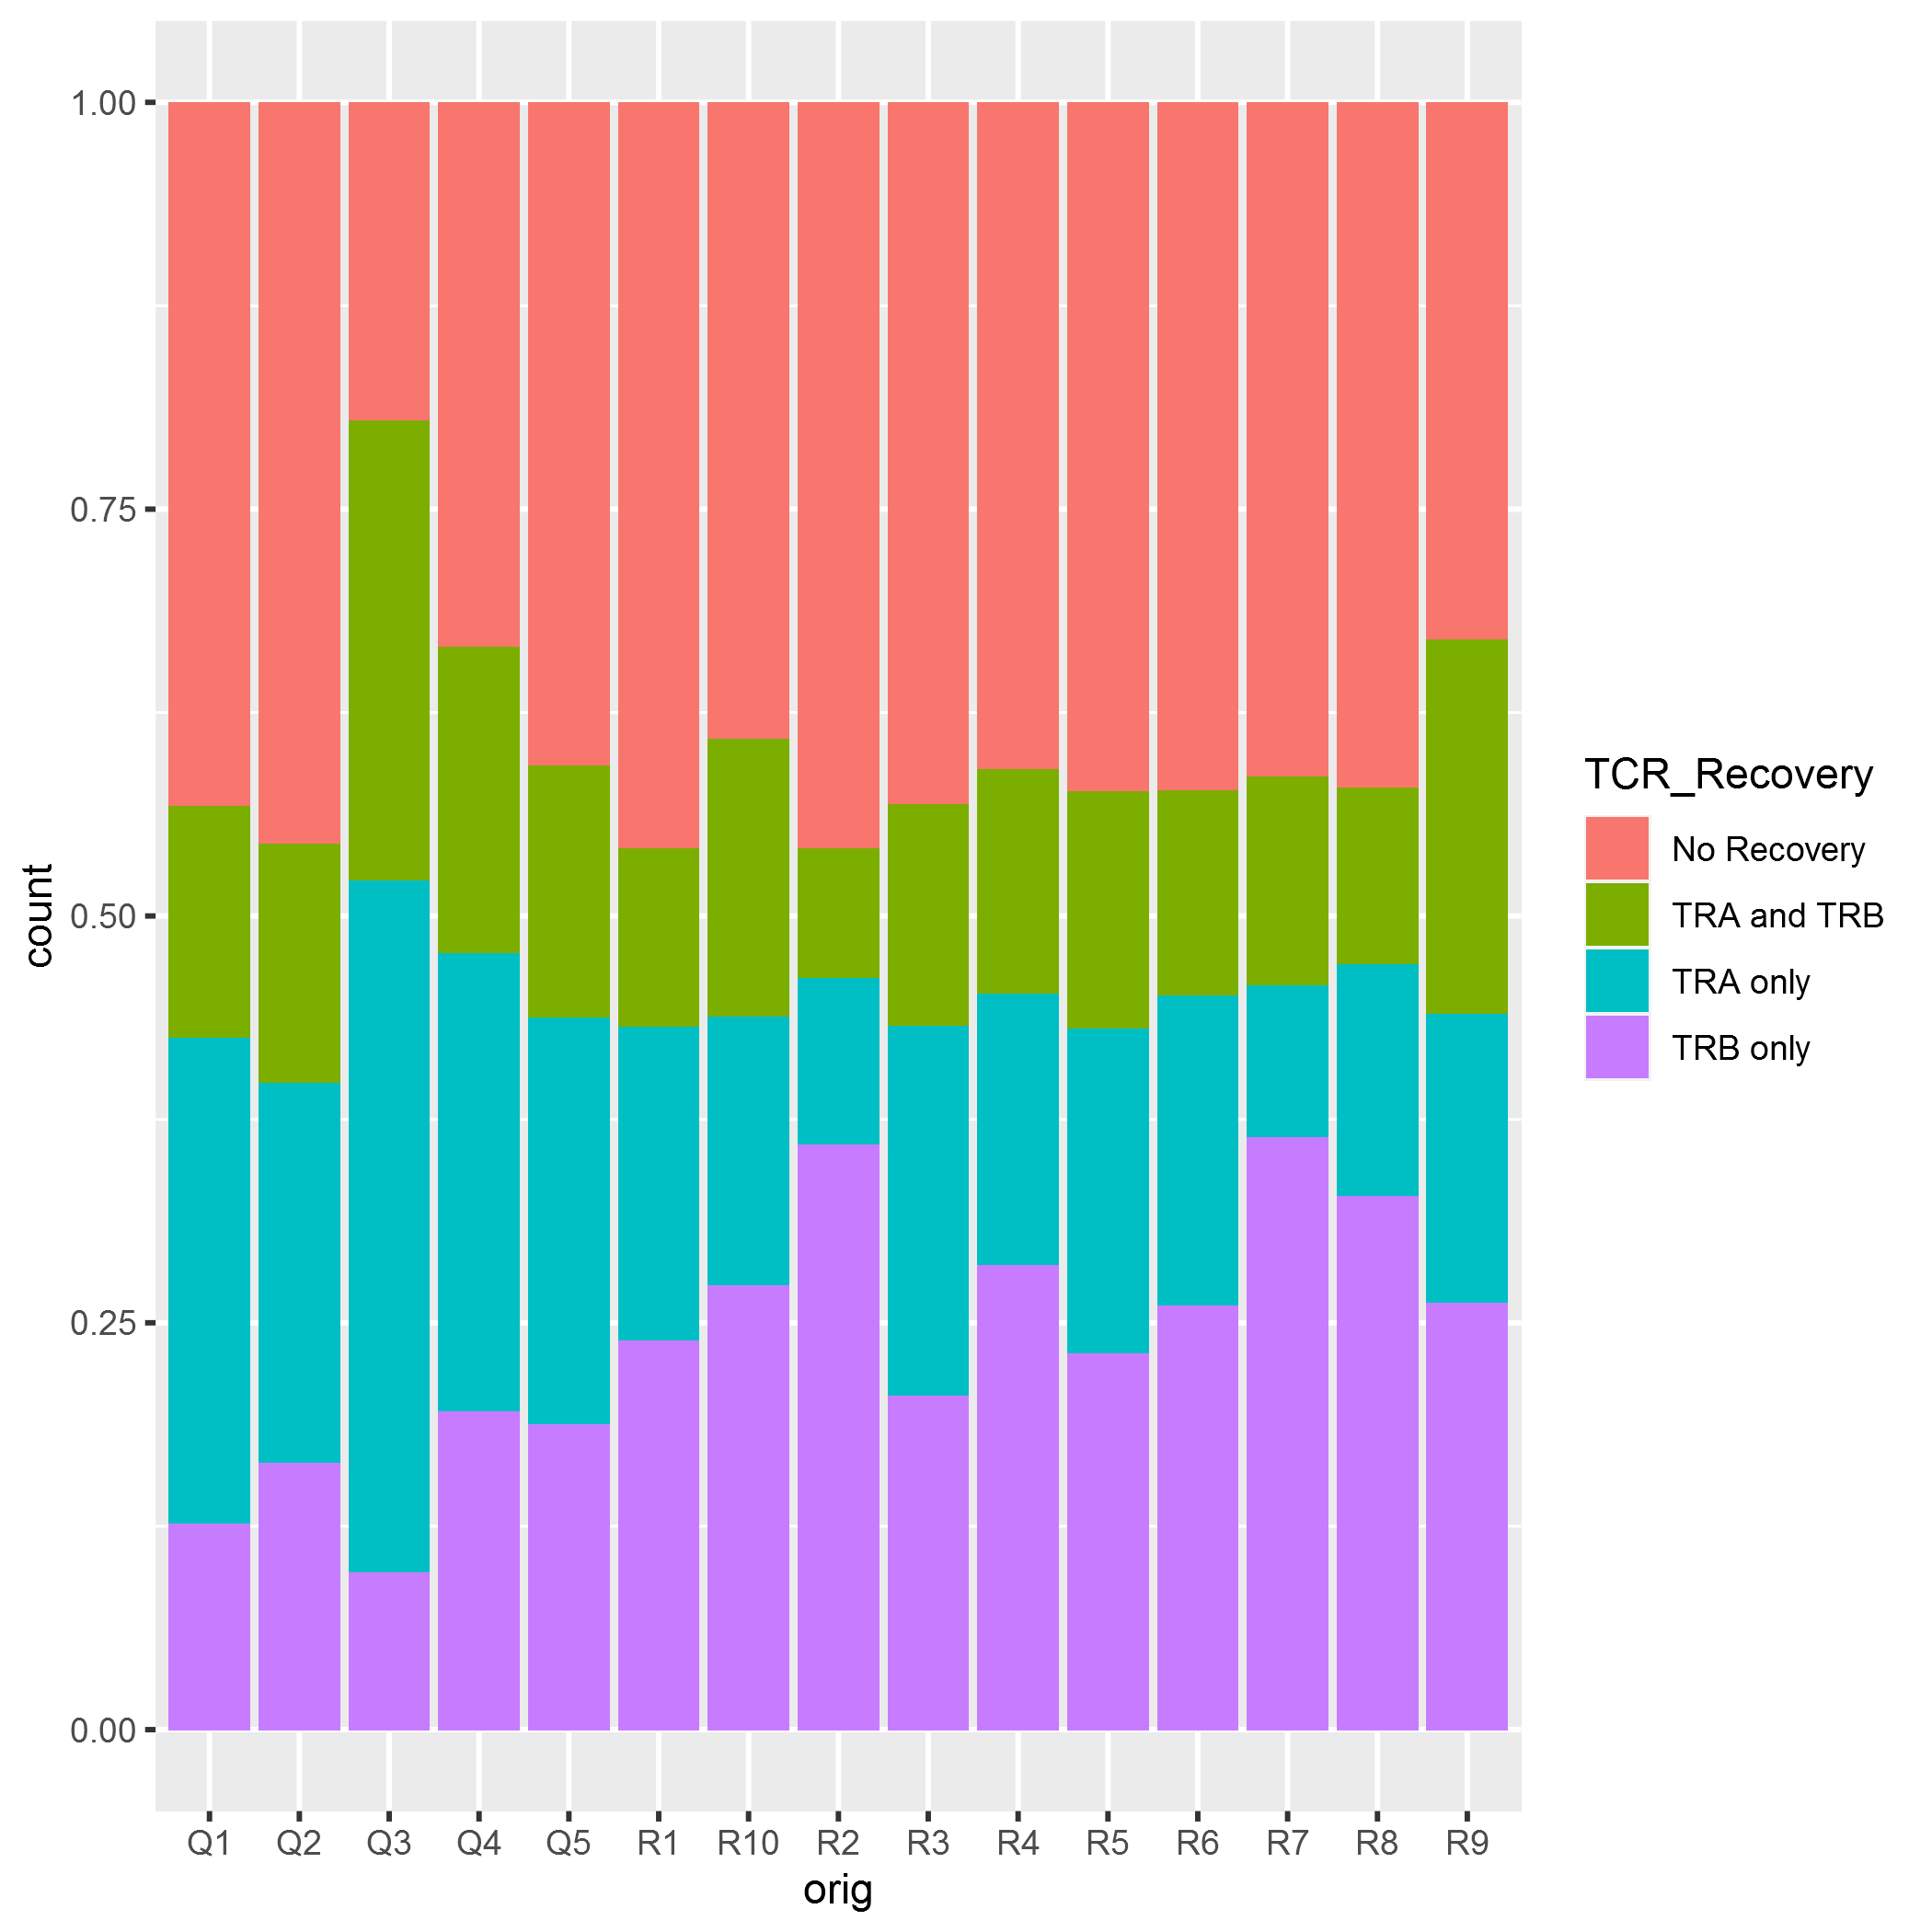

In [16]:
ggplot(metadata %>% filter(n_genes > 750), aes(x = orig, fill = TCR_Recovery)) + geom_bar(position = 'fill')

In [17]:
library(stringr)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*01', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*02', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*03', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*04', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*05', replacement = '', fixed = TRUE)
metadata$TRBJ = gsub(metadata$TRBJ, pattern = '*01', replacement = '', fixed = TRUE)
metadata$TRBJ = gsub(metadata$TRBJ, pattern = '*02', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*07', replacement = '', fixed = TRUE)

metadata$TRBV = sapply(metadata$TRBV, function(x) str_split(x, ',')[[1]][1])
metadata$TRBJ = sapply(metadata$TRBJ, function(x) str_split(x, ',')[[1]][1])

table(metadata$TRBV)
table(metadata$TRBJ)
                       
saveRDS(metadata, 'TCR_df.RDS')


   TRBV1 TRBV12-1 TRBV12-2 TRBV13-1 TRBV13-2 TRBV13-3   TRBV14   TRBV15 
     639      553     1095     1670     1753      846      525      505 
  TRBV16   TRBV17   TRBV19    TRBV2   TRBV20   TRBV23   TRBV24   TRBV26 
    1516      191      543      942      251       33       15     1320 
  TRBV29    TRBV3   TRBV30   TRBV31    TRBV4    TRBV5  TRBV5-2    TRBV6 
     462      770       48      409      199      905        1        1 
 TRBV7-2 
       2 


   TRBJ1-1    TRBJ1-2    TRBJ1-3    TRBJ1-4    TRBJ1-5 TRBJ1-5*03    TRBJ1-6 
      1132       1895        541        850        405          1        522 
   TRBJ2-1    TRBJ2-2    TRBJ2-3    TRBJ2-4    TRBJ2-5    TRBJ2-7 
      2021        553       1449       1132       1832       2861 

In [18]:
library(stringr)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*01', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*02', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*03', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*04', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*05', replacement = '', fixed = TRUE)
metadata$TRBJ = gsub(metadata$TRBJ, pattern = '*01', replacement = '', fixed = TRUE)
metadata$TRBJ = gsub(metadata$TRBJ, pattern = '*02', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*07', replacement = '', fixed = TRUE)

metadata$TRBV = sapply(metadata$TRBV, function(x) str_split(x, ',')[[1]][1])
metadata$TRBJ = sapply(metadata$TRBJ, function(x) str_split(x, ',')[[1]][1])

table(metadata$TRBV)
table(metadata$TRBJ)
                       
saveRDS(metadata, 'TCR_df.RDS')


   TRBV1 TRBV12-1 TRBV12-2 TRBV13-1 TRBV13-2 TRBV13-3   TRBV14   TRBV15 
     639      553     1095     1670     1753      846      525      505 
  TRBV16   TRBV17   TRBV19    TRBV2   TRBV20   TRBV23   TRBV24   TRBV26 
    1516      191      543      942      251       33       15     1320 
  TRBV29    TRBV3   TRBV30   TRBV31    TRBV4    TRBV5  TRBV5-2    TRBV6 
     462      770       48      409      199      905        1        1 
 TRBV7-2 
       2 


   TRBJ1-1    TRBJ1-2    TRBJ1-3    TRBJ1-4    TRBJ1-5 TRBJ1-5*03    TRBJ1-6 
      1132       1895        541        850        405          1        522 
   TRBJ2-1    TRBJ2-2    TRBJ2-3    TRBJ2-4    TRBJ2-5    TRBJ2-7 
      2021        553       1449       1132       1832       2861 